## CUDA SETUP

In [8]:
import torch

def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cpu device


## DATASET

In [9]:
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])

class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes = os.listdir(self.root_dir)

        # self.classes if a dataset type is "test"
        if self.dataset_type == "test":
            self.classes = os.listdir(self.root_dir)
            test_classes = []
            for class_ in self.classes:
                class_name = class_.replace("_test.jpg", "")
                test_classes.append(class_name)
            self.classes = test_classes

    def __len__(self):
        if self.dataset_type == "train":
            dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.classes])
        elif self.dataset_type == "test":
            dataset_len = len(os.listdir(self.root_dir))
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        if self.dataset_type == "train":
            items_in_class = 3000 # Every class has 3000 items
            class_ = self.classes[index // items_in_class]
            image_path = os.path.join(self.root_dir, class_) + f"/{class_}{index % (items_in_class)+1}.jpg"
            label = class_
            
        elif self.dataset_type == "test":
            class_ = self.classes[index]
            image_path = os.path.join(self.root_dir, class_) + f"_test.jpg"
            label = class_
        
        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [10]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./dataset/asl_alphabet_train/", 
                        transform=transform,
                        dataset_type="train")

Dataset len:
87000

Dataset classes:
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


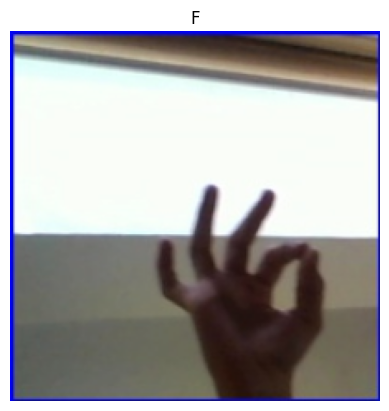

In [11]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [12]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./dataset/asl_alphabet_test/", 
                        transform=transform,
                        dataset_type="test")

Dataset len:
28

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'nothing', 'N', 'O', 'P', 'Q', 'R', 'space', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random image from dataset:


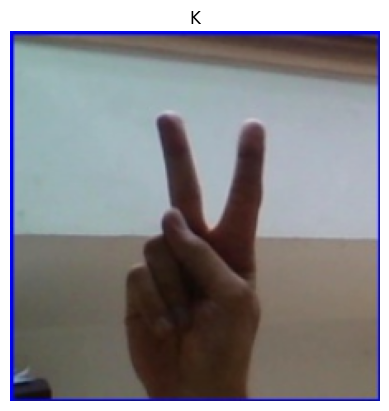

In [13]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()

## DATALOADER

In [14]:
train_dataloader = None


## DATALOADER